In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from medmnist import BloodMNIST

2025-04-28 12:07:46.479658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745856466.498648   19536 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745856466.504465   19536 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745856466.519588   19536 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745856466.519609   19536 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745856466.519612   19536 computation_placer.cc:177] computation placer alr

In [2]:
import random
import os

def set_seed(seed=123):
    os.environ['PYTHONHASHSEED'] = str(seed)  
    random.seed(seed)                         
    np.random.seed(seed)                      
    tf.random.set_seed(seed)                  

set_seed(123)

## Resolution: 64x64

### ResNet50_64

In [3]:
# 1. Load dataset
data_64 = np.load("bloodmnist_64.npz")

# 2. Extract images and labels
train_images_64 = data_64["train_images"]
train_labels_64 = data_64["train_labels"].flatten()

val_images_64 = data_64["val_images"]
val_labels_64 = data_64["val_labels"].flatten()

test_images_64 = data_64["test_images"]
test_labels_64 = data_64["test_labels"].flatten()

In [4]:
data_64.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [5]:
# 3. One-hot encode labels
train_labels_cat_64 = to_categorical(train_labels_64, num_classes=8)
val_labels_cat_64 = to_categorical(val_labels_64, num_classes=8)
test_labels_cat_64 = to_categorical(test_labels_64, num_classes=8)

In [6]:
# 4. Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32 # increase batch size to 32 from 16

train_generator_64 = train_datagen.flow(
    train_images_64, 
    train_labels_cat_64,   
    batch_size=batch_size
)
val_generator_64 = test_datagen.flow(
    val_images_64,
    val_labels_cat_64,
    batch_size=batch_size
)
test_generator_64 = test_datagen.flow(
    test_images_64,
    test_labels_cat_64,
    batch_size=batch_size,
    shuffle=False
)

In [7]:
# 5. Set up ResNet50 
base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

2025-04-28 12:08:25.901491: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
# 6. Compile model 

model_50_64.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
history_50_64 = model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64
)

In [9]:
model_50_64.save('ResNet50_64.h5')
model_50_64.save('ResNet50_64.keras')

# to load:
# from keras.models import load_model
# model_101_64 = load_model('model_101_64.h5')
# from tensorflow.keras.models import load_model
# model_50_64 = load_model('model_50_64.keras', compile=Trye)

In [15]:
from tensorflow.keras.models import load_model
model_50_64 = load_model('model_output/ResNet50_64.keras', compile=True)

In [16]:
# 8. Evaluate model
test_loss_50_64, test_acc_50_64, test_auc_50_64 = model_50_64.evaluate(test_generator_64)
print(f"ResNet50 test accuracy for 64 pixels: {test_acc_50_64:.4f}")
print(f"ResNet50 test AUC for 64 pixels:      {test_auc_50_64:.4f}")

/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.9747 - auc: 0.9969 - loss: 0.0917
ResNet50 test accuracy for 64 pixels: 0.9775
ResNet50 test AUC for 64 pixels:      0.9966


In [17]:
# 9. Precision, recall, f1-score
y_prob_50_64 = model_50_64.predict(test_generator_64)
y_pred_50_64 = np.argmax(y_prob_50_64, axis=1)
y_true_64 = test_labels_64

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_64, y_pred_50_64, target_names=class_names))

107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step
                      precision    recall  f1-score   support

          neutrophil       0.97      0.99      0.98       244
          eosinophil       0.99      1.00      1.00       624
            basophil       0.99      0.97      0.98       311
          lymphocyte       0.97      0.93      0.95       579
            monocyte       0.99      0.97      0.98       243
immature granulocyte       0.96      0.98      0.97       284
        erythroblast       0.95      0.98      0.97       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.98      3421
           macro avg       0.98      0.98      0.98      3421
        weighted avg       0.98      0.98      0.98      3421



In [18]:
# 10. Performance per class
cm_50_64 = confusion_matrix(y_true_64, y_pred_50_64)
per_class_acc_50_64 = cm_50_64.diagonal() / cm_50_64.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_64):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

neutrophil           accuracy: 0.9918
eosinophil           accuracy: 1.0000
basophil             accuracy: 0.9743
lymphocyte           accuracy: 0.9344
monocyte             accuracy: 0.9671
immature granulocyte accuracy: 0.9754
erythroblast         accuracy: 0.9790
platelet             accuracy: 1.0000


In [ ]:
# 11. Plot
epochs = range(1, len(history_50_64.history['loss']) + 1)

# accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_50_64.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (64x64) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet50_64.png")
plt.show()

# auc
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64.history['auc'], label='Training AUC')
plt.plot(epochs, history_50_64.history['val_auc'], label='Validation AUC')
plt.title('ResNet50 (64x64) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet50_64.png")
plt.show()

# loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64.history['loss'], label='Training Loss')
plt.plot(epochs, history_50_64.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (64x64) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet50_64.png")
plt.show()

### ResNet101_64

In [20]:
base_101_64 = ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_101_64.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_101_64 = Model(inputs=base_101_64.input, outputs=outputs)

In [21]:
# 6. Compile model
model_101_64.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
)

In [22]:
# 7. Train model
print("model_101_64")

history_101_64 = model_101_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64
)

model_101_64
Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 962s 2s/step - accuracy: 0.7789 - auc: 0.9427 - loss: 0.7148 - val_accuracy: 0.1373 - val_auc: 0.5000 - val_loss: 145.5909
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 927s 2s/step - accuracy: 0.9494 - auc: 0.9959 - loss: 0.1537 - val_accuracy: 0.1729 - val_auc: 0.7709 - val_loss: 2.9386
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 928s 2s/step - accuracy: 0.9681 - auc: 0.9980 - loss: 0.0945 - val_accuracy: 0.9492 - val_auc: 0.9970 - val_loss: 0.1609
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 929s 2s/step - accuracy: 0.9731 - auc: 0.9987 - loss: 0.0808 - val_accuracy: 0.9766 - val_auc: 0.9986 - val_loss: 0.0831
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 929s 2s/step - accuracy: 0.9780 - auc: 0.9987 - loss: 0.0672 - val_accuracy: 0.9492 - val_auc: 0.9946 - val_loss: 0.1511
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 929s 2s/step - accuracy: 0.9814 - auc: 0.9989 - loss: 0.0583 - val_accuracy: 0.9591 - val_auc: 0.9936 - val_loss: 0.1361
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 928

In [35]:
model_101_64.save('model_output/ResNet101_64.h5')
model_101_64.save('model_output/ResNet101_64.keras')

# to load:
# from keras.models import load_model
# model_101_64 = load_model('model_101_64.keras')

# from tensorflow.keras.models import load_model
# model_101_64 = load_model('model_101_64.h5', compile=True)

In [36]:
model_101_64.optimizer

In [24]:
# 8. Evaluate model
test_loss_101_64, test_acc_101_64, test_auc_101_64 = model_101_64.evaluate(test_generator_64)
print(f"ResNet101 test accuracy for 64 pixels: {test_acc_101_64:.4f}")
print(f"ResNet101 test AUC for 64 pixels:      {test_auc_101_64:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - accuracy: 0.9677 - auc: 0.9967 - loss: 0.0984
ResNet101 test accuracy for 64 pixels: 0.9667
ResNet101 test AUC for 64 pixels:      0.9965


In [25]:
# 9. Classification report
y_prob_101_64 = model_101_64.predict(test_generator_64)
y_pred_101_64 = np.argmax(y_prob_101_64, axis=1)
y_true_64 = test_labels_64

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}
class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_64, y_pred_101_64, target_names=class_names))

107/107 ━━━━━━━━━━━━━━━━━━━━ 28s 234ms/step
                      precision    recall  f1-score   support

          neutrophil       0.92      0.99      0.96       244
          eosinophil       1.00      1.00      1.00       624
            basophil       0.99      0.98      0.98       311
          lymphocyte       0.91      0.94      0.92       579
            monocyte       0.99      0.93      0.96       243
immature granulocyte       0.95      0.90      0.92       284
        erythroblast       0.97      0.97      0.97       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.97      3421
           macro avg       0.97      0.96      0.96      3421
        weighted avg       0.97      0.97      0.97      3421



In [26]:
# 10. Per-class accuracy
cm_101_64 = confusion_matrix(y_true_64, y_pred_101_64)
per_class_acc_101_64 = cm_101_64.diagonal() / cm_101_64.sum(axis=1)
for i, acc in enumerate(per_class_acc_101_64):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

neutrophil           accuracy: 0.9918
eosinophil           accuracy: 0.9968
basophil             accuracy: 0.9807
lymphocyte           accuracy: 0.9378
monocyte             accuracy: 0.9342
immature granulocyte accuracy: 0.9014
erythroblast         accuracy: 0.9655
platelet             accuracy: 0.9979


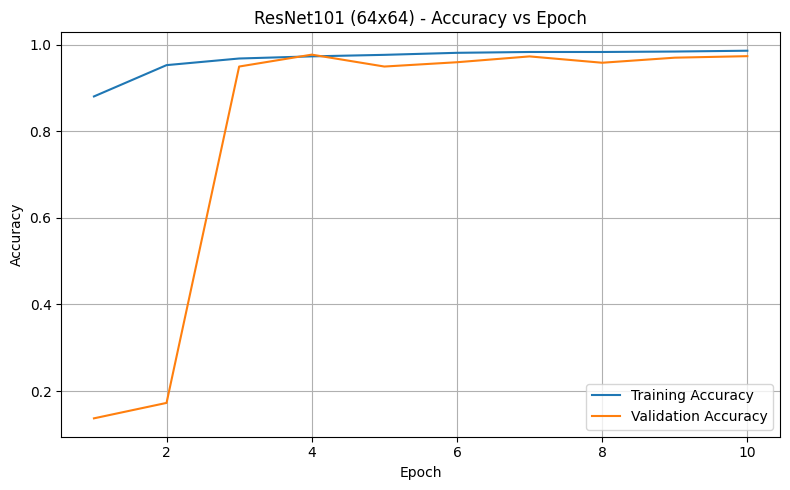

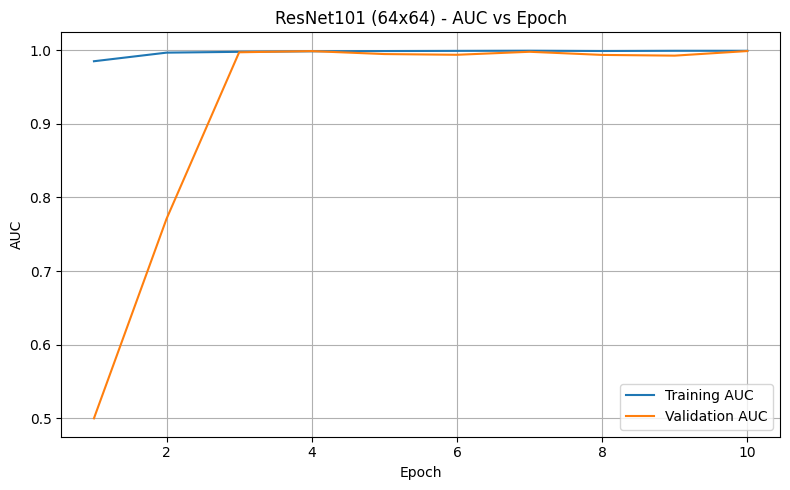

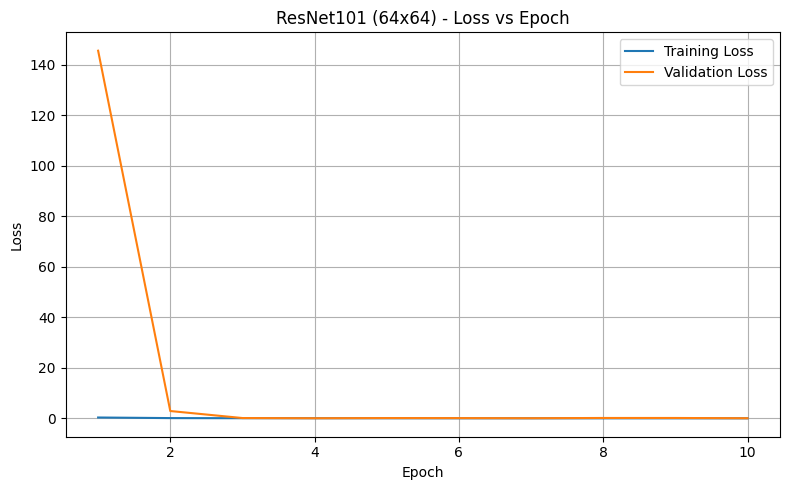

In [27]:
# 11. Plots
epochs = range(1, len(history_101_64.history['loss']) + 1)

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_64.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_101_64.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet101 (64x64) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet101_64.png")
plt.show()

# AUC plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_64.history['auc'], label='Training AUC')
plt.plot(epochs, history_101_64.history['val_auc'], label='Validation AUC')
plt.title('ResNet101 (64x64) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet101_64.png")
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_101_64.history['loss'], label='Training Loss')
plt.plot(epochs, history_101_64.history['val_loss'], label='Validation Loss')
plt.title('ResNet101 (64x64) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet101_64.png")
plt.show()